# ПРОЕКТ №4. Изучение оттока клиентов фитнес-клуба
____

# Цели и задачи проекта:
  - Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
  - Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
  - Проанализировать основные признаки, наиболее сильно влияющие на отток;
  - Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами

# Входные данные:
Таблица **logs_exp**:
 - **churn** — факт оттока в текущем месяце;
 - **gender** — пол;
 - **near_location** — проживание или работа в районе, где находится фитнес-центр;
 - **partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - **promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - **phone** — наличие контактного телефона;
 - **age** — возраст;
 - **lifetime** — время с момента первого обращения в фитнес-центр (в месяцах).
 - **contract_period** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 - **month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах);
 - **group_visits** — факт посещения групповых занятий;
 - **avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента;
 - **avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц;
 - **vg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

<a id='0.'></a>
# Содержание:

1. [Исследовательский анализ данных](#1.)
<p></p>

2. [Модель прогнозирования оттока клиентов](#2.)
<p></p>

3. [Кластеризация клиентов](#3.)
<p></p>

4. [Выводы и базовые рекомендации по работе с клиентами](#4.)
<p></p>  

4. [Изучение результатов эксперимента](#4.)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.display.max_colwidth = 150


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans


In [3]:
try:
    data = pd.read_csv('gym_churn.csv')
except:
    data = pd.read_csv('/datasets/gym_churn.csv')

data.columns = [i.lower() for i in data.columns]
# Данные без целевой переменной:
data_wo_churn = data.drop(['churn'], axis=1)
data.head()


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# Единицы измерения нецелевых признаков:
SIGNS_UNITS_DICT = {'gender': 'муж / жен',
                    'near_location': 'да=1 / нет=0',
                    'partner': 'да=1 / нет=0',
                    'promo_friends': 'да=1 / нет=0',
                    'phone': 'да=1 / нет=0',
                    'group_visits': 'да=1 / нет=0',
                    'contract_period': 'месяцы',
                    'age': 'годы',
                    'avg_additional_charges_total': 'ден. единицы',
                    'month_to_end_contract': 'месяцы',
                    'lifetime': 'месяцы',
                    'avg_class_frequency_total': 'посещения',
                    'avg_class_frequency_current_month': 'посещения'}


In [5]:
# Списки с бинарными и небинарными признаками(целевой признак churn
# не учитываю):
BINARY_SIGNS = []
NONBINARY_SIGNS = []
for sign in data_wo_churn:
    if len(data[sign].unique()) <= 2:
        BINARY_SIGNS.append(sign)
    else:
        NONBINARY_SIGNS.append(sign)
print('Бинарные признаки:', BINARY_SIGNS)
print('Небинарные признаки:', NONBINARY_SIGNS)


Бинарные признаки: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
Небинарные признаки: ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']


[К содержанию](#0.)
<a id='1.'></a>
# 1. Исследовательский анализ данных

Определю, есть ли пропуски в данных и найду значения основных статистик:

In [6]:
round(data.describe().T, 3)


,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510,0.500,0.000,0.000,1.000,1.000,1.000
near_location,4000.0,0.845,0.362,0.000,1.000,1.000,1.000,1.000
partner,4000.0,0.487,0.500,0.000,0.000,0.000,1.000,1.000
promo_friends,4000.0,0.308,0.462,0.000,0.000,0.000,1.000,1.000
phone,4000.0,0.904,0.295,0.000,1.000,1.000,1.000,1.000
contract_period,4000.0,4.681,4.550,1.000,1.000,1.000,6.000,12.000
group_visits,4000.0,0.412,0.492,0.000,0.000,0.000,1.000,1.000
age,4000.0,29.184,3.258,18.000,27.000,29.000,31.000,41.000
avg_additional_charges_total,4000.0,146.944,96.356,0.148,68.869,136.220,210.950,552.591
month_to_end_contract,4000.0,4.323,4.191,1.000,1.000,1.000,6.000,12.000


Сопоставлю средние значения признаков в двух группах — с теми, кто ушел в отток и теми, кто остался:

In [7]:
signsMeansByGroups = data.groupby('churn').mean().T
signsMeansByGroups


churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


У признаков разный масштаб. Поэтому сравню их нормированные значения, поделив каждый из столбцов на среднее значение по признаку(без учета факта оттока). Это поможет компактно показать на одной столбчатой диаграмме соотношения средних величин всех признаков для ушедших и оставшихся клиентов. Преобразую таблицу **signsMeansByGroups** к вертикальному виду и нормализую в ней значения: 

In [8]:
# Вертикальное объединение таблиц:
def get_normal_signs(signsMeansByGroups, signsMeans, group_sign):
    # Объявление итогового датафрейма:
    normalSigns = pd.DataFrame()
    for column in signsMeansByGroups.columns:
        # Вертикальное объединение текущей итоговой таблицы с новыми данными:
        normalSigns = pd.concat(
            [normalSigns,
             # Добавляю таблицу со столбцами "признак"-"группирующий признак":
             pd.DataFrame(data={
                 'norm_value': signsMeansByGroups[column] / signsMeans,
                 group_sign: column})]
        )
    return normalSigns


In [9]:
signsMeans = data_wo_churn.describe().T['mean']
# Нормализация значений признаков:
normalSigns = get_normal_signs(signsMeansByGroups,
                               signsMeans,
                               group_sign='churn')
# Замена обозначений оттока на более интуитивные для будущей диаграммы:
normalSigns['churn'] = (
    normalSigns['churn'].
    replace([0, 1], ['Остались в клубе', 'Покинули клуб'])
    )
normalSigns.sample(5)


,norm_value,churn
near_location,0.908776,Покинули клуб
avg_additional_charges_total,1.078275,Остались в клубе
gender,0.999583,Остались в клубе
month_to_end_contract,1.222159,Остались в клубе
partner,0.729995,Покинули клуб


Построю диаграмму с нормализованными значениями:

In [10]:
def show_normal_signs_diagram(data, figsize, group_sign, order):
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=data['norm_value'], y=data.index, hue=data[group_sign],
                     hue_order=order)
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.7,
               label='Уровень среднего\nзначения по \nвсей выборке')
    ax.set_title('Сравнение средних значений признаков',
                 fontdict={'fontsize': 13, 'fontweight': 'bold'})
    ax.set_xlabel('Отношение среднего значения по группе '
                   'к среднему значению по всей выборке',
                  fontdict={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_ylabel('Признак', fontdict={'fontsize': 11, 'fontweight': 'bold'})
    ax.legend()
    sns.despine()

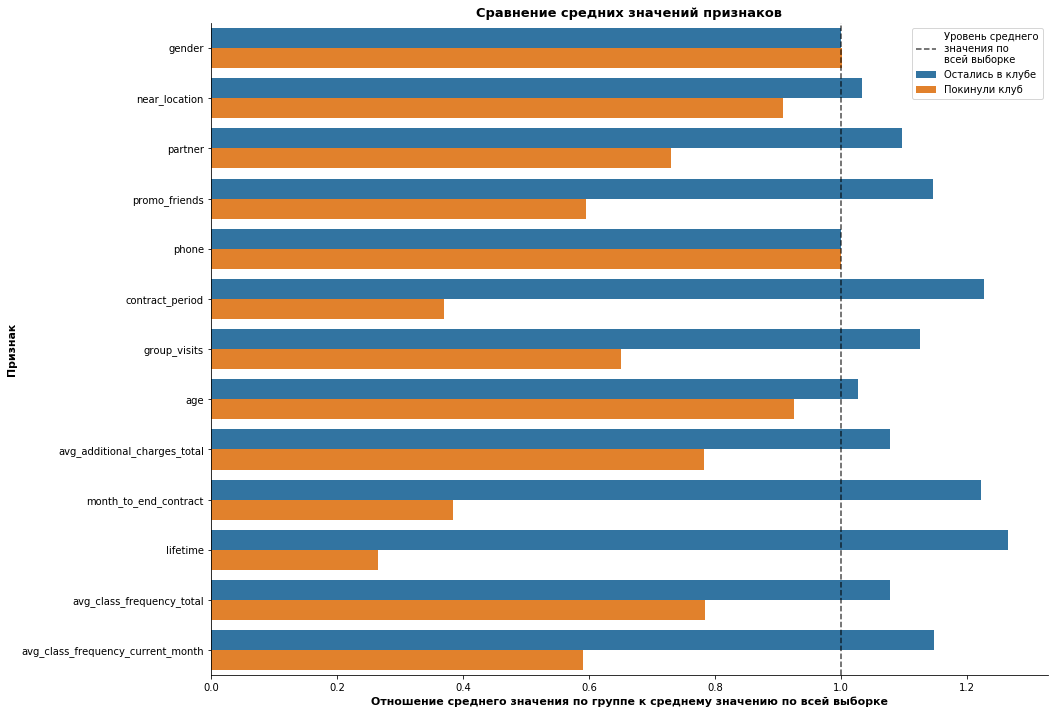

In [11]:
show_normal_signs_diagram(data=normalSigns,
                          figsize=(15, 12),
                          group_sign='churn',
                          order=normalSigns['churn'].unique().tolist()
                          )


Для небинарных признаков покажу распределение значений:

In [12]:
def show_sign_distributions(figsize, data, group_sign, xlabel, order):
    for sign in NONBINARY_SIGNS:
        plt.figure(figsize=figsize)
        # Ящик с усами:
        ax = sns.boxplot(data=data, x=group_sign, y=sign,
                         notch=True, order=order, fliersize=0)
        # Точечная диаграмма разброса:
        sns.stripplot(data=data, x=group_sign, y=sign, color='green',
                      alpha=0.5, size=5, linewidth=0.4, ax=ax, order=order)
        ax.set_title(sign, fontdict={'fontsize': 13, 'fontweight': 'bold'})
        ax.set_xlabel(xlabel, fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.set_ylabel(SIGNS_UNITS_DICT[sign],
                      fontdict={'fontsize': 11, 'fontweight': 'bold'})
        sns.despine()


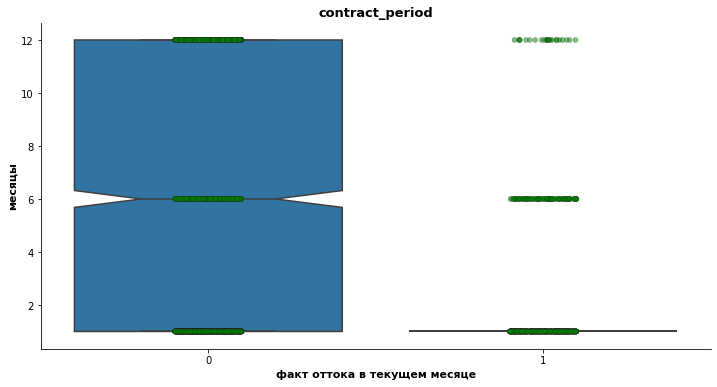

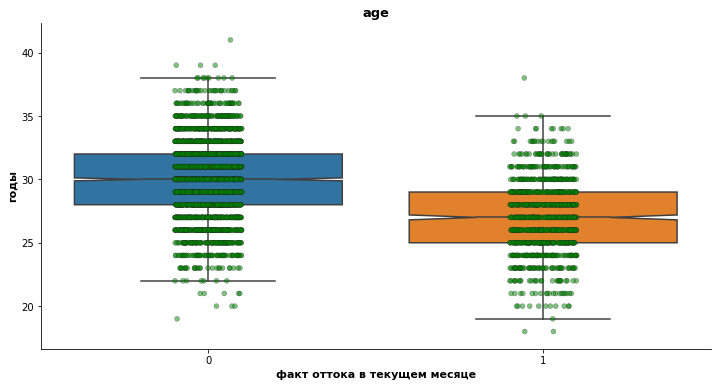

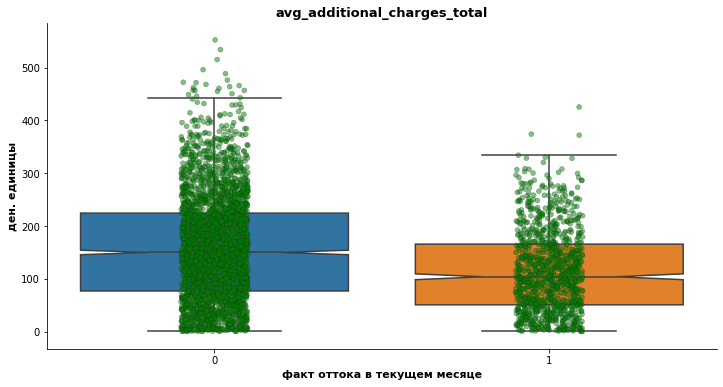

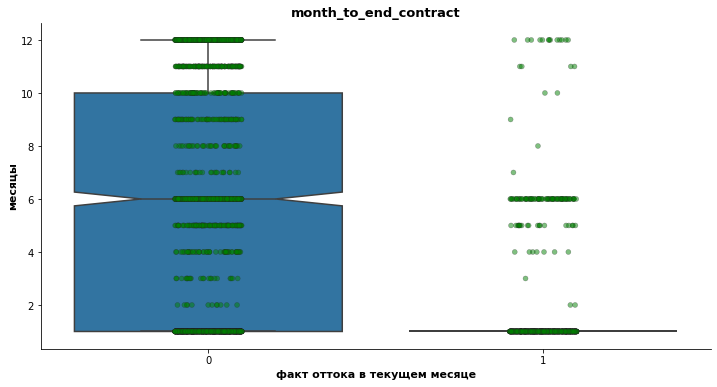

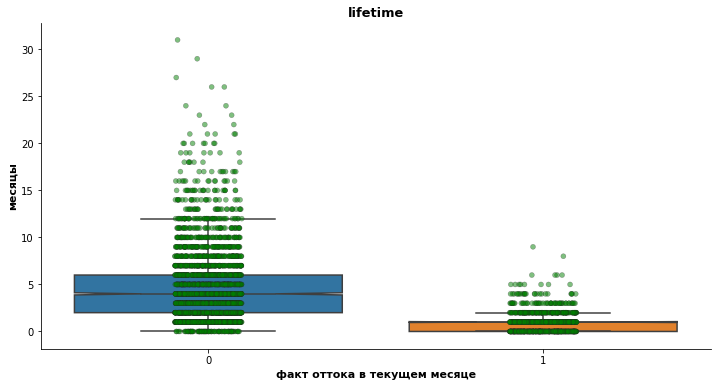

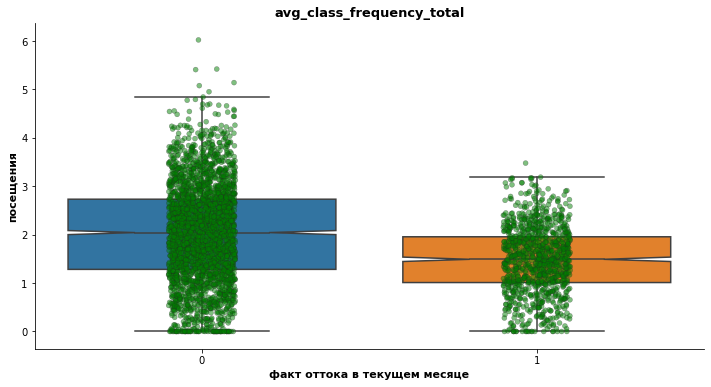

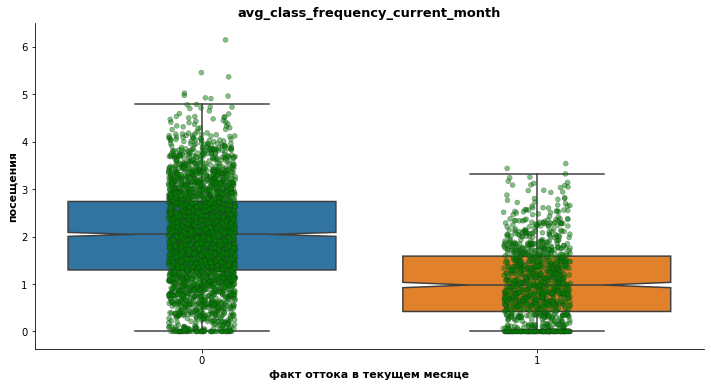

In [13]:
show_sign_distributions(figsize=(12, 6),
                        data=data,
                        group_sign='churn',
                        xlabel='факт оттока в текущем месяце',
                        order=[0, 1]
                        )


Матрица корреляции по признакам:

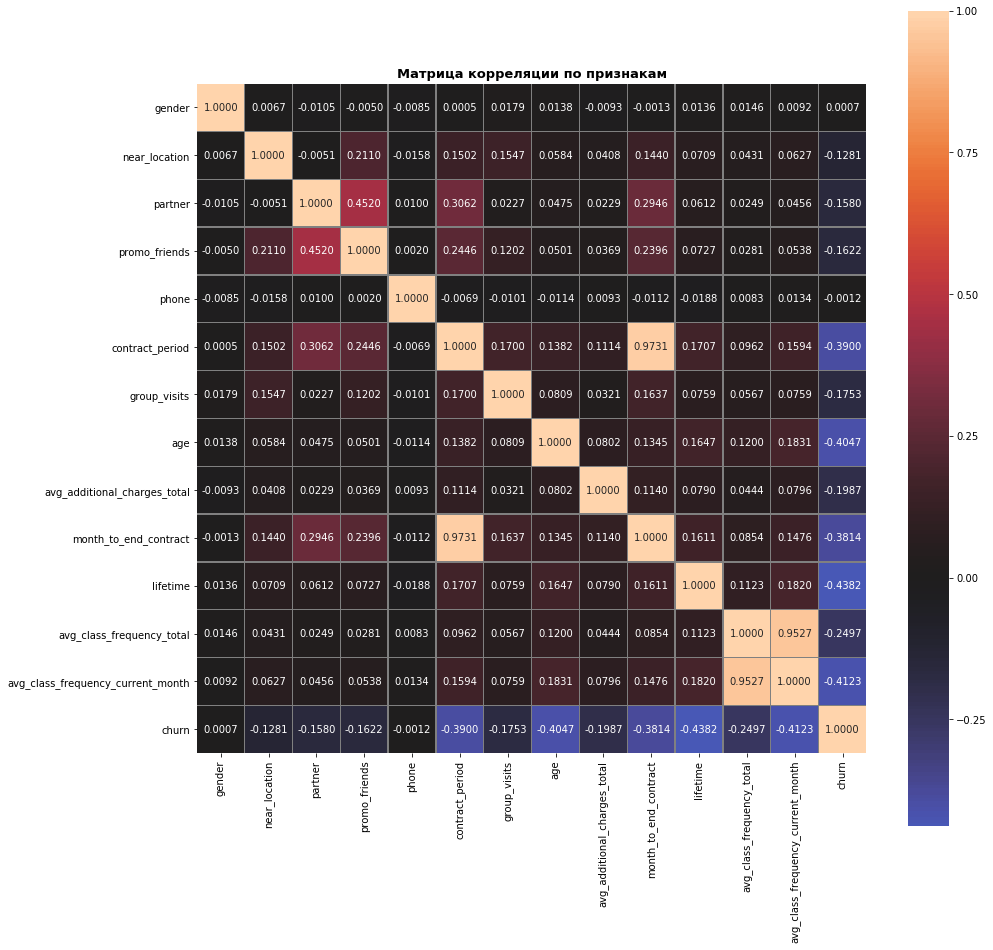

In [14]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(data.corr(),
                 fmt='.4f',
                 annot=True,
                 linewidths=0.3,
                 linecolor='grey',
                 center=0,
                 square=True
                 )
ax.set_title('Матрица корреляции по признакам', fontdict={'fontsize': 13, 'fontweight': 'bold'})
plt.show()


**Выводы**:
 - В данные нет пропусков
 - Выявились следующие закономерности оставшихся клиентов (в отличие от ушедших):
  - Они чаще занимаются по партнерской программе
  - Их чаще приводят друзья
  - Они чаще посещают групповые занятия
  - Средний объем действующего абоненемента у них значительно больше
  - Они, в целом, старше
  - Срок до окончания абонемента заметно больше
  - Они уже занимаются значительно дольше
  - Частота посещения клуба выше
 - Присутствуют признаки с заметной корреляцией (>0.8 по модулю):
  - month_to_end_contract / contract_period
  - avg_class_frequency_current_month / avg_additional_charges_total

[К содержанию](#0.)
<a id='2.'></a>
# 2. Модель прогнозирования оттока клиентов

Построю модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце (**churn**). Сначала разделю данные на обучающую и валидационную выборку:

In [15]:
# Матрица объект-признак без целевой переменной:
X = data_wo_churn
# Вектор целевой переменной:
y = data['churn']
# Разделение выборки на тренировочную и тестовую:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=0)


Обучу модель на train-выборке логистической регрессией:

In [16]:
# Словарь с предсказаниями для разных алгоритмов:
y_pred_dict = {}
model = LogisticRegression(random_state=0, solver='liblinear')
model.fit(X_train, y_train)
# Результат для логистической регрессии:
y_pred_dict['Логистическая регрессия'] = model.predict(X_test)


Обучу модель на train-выборке случайным лесом:

In [17]:
model = RandomForestClassifier(random_state=0, n_estimators=100)
model.fit(X_train, y_train)
y_pred_tree = model.predict(X_test)
# Результат для случайного леса:
y_pred_dict['Случайный лес'] = model.predict(X_test)


Сравню метрики accuracy, precision и recall для обеих моделей на валидационной выборке:

In [18]:
for model in ['Логистическая регрессия', 'Случайный лес']:
    y_pred = y_pred_dict[model]
    print('Метрики для алгоритма \"{}\":'.format(model))
    print('Accuracy =', accuracy_score(y_test, y_pred))
    print('Precision =', precision_score(y_test, y_pred))
    print('Recall =', recall_score(y_test, y_pred))
    print('\n')


Метрики для алгоритма "Логистическая регрессия":
Accuracy = 0.93
Precision = 0.88
Recall = 0.8461538461538461


Метрики для алгоритма "Случайный лес":
Accuracy = 0.918
Precision = 0.8647540983606558
Recall = 0.8115384615384615




**Вывод**: По всем трем метрикам алгоритм "Логистическая регрессия" оказался незначительно, но лучше алгоритма "Случайный лес". Учитывая, что здесь вряд ли может случиться баланс классов - использовать метрику **Accuracy** не представляется возможным. Наиболее уместной здесь метрикой для оценки алгоритмов я считаю **Recall**, т.к. основная цель исследования - получить информацию, которая поможет уменьшить отток. Лучше перемотивировать лояльного клиента, чем недомотивировать возможного отступника. 

[К содержанию](#0.)
<a id='3.'></a>
#  3. Кластеризация клиентов

Стандартизирую данные:

In [19]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(data_wo_churn)


Построю матрицу расстояний функцией на стандартизованной матрице признаков и нарисую дендрограмму:

In [20]:
linked = linkage(X_sc, method='ward')


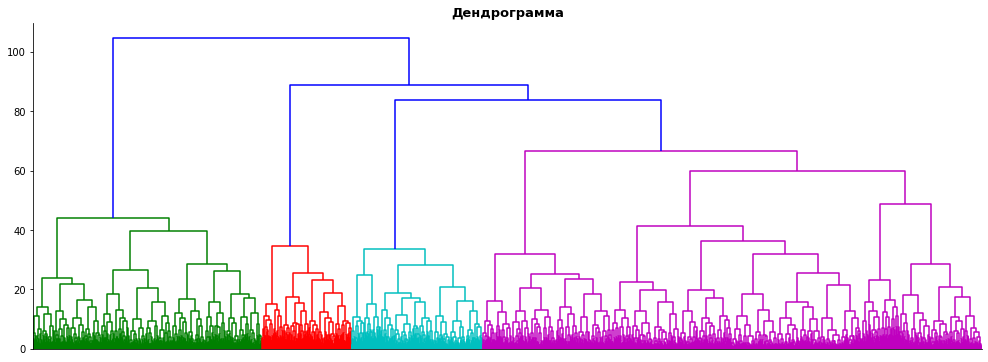

In [21]:
plt.figure(figsize=(17, 6))
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендрограмма', fontdict={'fontsize': 13, 'fontweight': 'bold'})
sns.despine()


Предложенное оптимальное число кластеров:

In [22]:
linked.shape[1]


4

Обучу модель кластеризации на основании алгоритма K-Means и спрогнозирую кластеры клиентов. Приму число кластеров = 5.

In [23]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)


Добавлю в выборку столбец с кластерами:

In [24]:
data['cluster'] = labels


Покажу средние значения признаков для кластеров. Столбцы будут расположены в порядке увеличения доли оттока (**churn**).

In [25]:
signsMeansByGroups = data.groupby('cluster').mean().sort_values(by='churn').T
signsMeansByGroups


cluster,0,4,1,2,3
gender,0.502473,0.560335,0.522078,0.495050,0.485737
near_location,0.959446,0.976105,0.862338,0.000000,1.000000
partner,0.783383,0.356033,0.470130,0.463366,0.350238
promo_friends,0.574679,0.229391,0.306494,0.079208,0.240095
phone,1.000000,0.998805,0.000000,1.000000,1.000000
contract_period,10.884273,2.665472,4.787013,2.352475,1.948494
group_visits,0.543027,0.473118,0.425974,0.215842,0.341521
age,29.980218,30.127838,29.301299,28.477228,28.167987
avg_additional_charges_total,160.706969,161.724258,143.957664,135.457501,131.622204
month_to_end_contract,9.950544,2.455197,4.475325,2.198020,1.856577


По таблице можно заметить следующее:
 - Наличие нулевых значений:
  - Группа 4, признак near_location
  - Группа 2, признак phone  
 Скорее всего, это говорит не о закономерностях, а об ошибке в работе алгоритма
 - Есть обратная корреляция оттока с признаками:
  - **promo_friends**  
  (отток в группе тем меньше, чем выше доля клиентов, пришедших по совету друга)
  - **contract_period**  
  (отток в группе тем меньше, чем выше средний размер абонемента)
  - **group_visits**  
  (отток в группе тем меньше, чем выше доля посетителей совместных занятий)
  - **avg_additional_charges_total**  
  (отток в группе тем меньше, чем больше тратятся на доп. услуги)
  - **lifetime**  
  (отток в группе тем меньше, чем выше доля "старожил")
  - **avg_class_frequency_total**  
  (отток в группе тем меньше, чем выше средняя посещаемость)
  - **avg_class_frequency_current_month**  
  (отток в группе тем меньше, чем выше средняя посещаемость за последний месяц)
 - Две группы с минимальным оттоком: 0 и 4.

Построю наглядные диаграммы (сравнение средних значений признаков и распределение значений небинарных признаков). Сначала приведу к вертикальному виду таблицу **signsMeansByGroups** и нормализую в ней значения:

In [26]:
# Данные без номера кластера:
data_wo_cluster = data.drop(['cluster'], axis=1)
# Средние значения в данных без номера кластера:
signsMeans = data_wo_cluster.describe().T['mean']
# Нормализованные значения:
normalSigns = get_normal_signs(signsMeansByGroups, signsMeans,
                               group_sign='cluster')
normalSigns.sample(5)


,norm_value,cluster
near_location,1.154812,4
lifetime,1.272266,0
contract_period,0.502531,2
avg_class_frequency_total,1.055500,0
contract_period,0.416234,3


Построю диаграмму с нормализованными значениями (для каждого признака столбцы располагаются сверху вниз в порядке увеличения оттока в кластере):

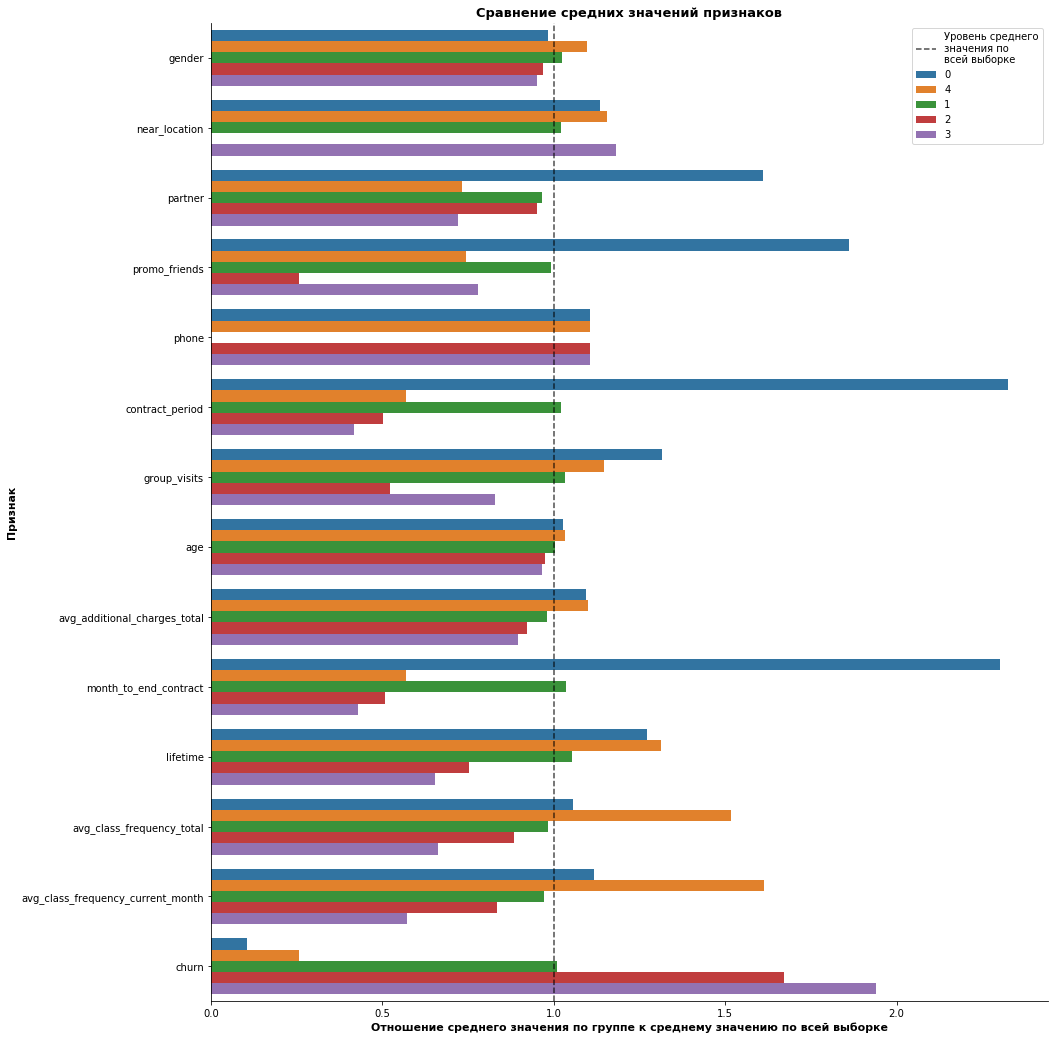

In [27]:
show_normal_signs_diagram(data=normalSigns,
                          figsize=(15, 18),
                          group_sign='cluster',
                          order=signsMeansByGroups.columns.to_list()
                          )


Для небинарных признаков покажу распределение значений (графики расположены слева направо в порядке увеличения доли оттока в кластере):

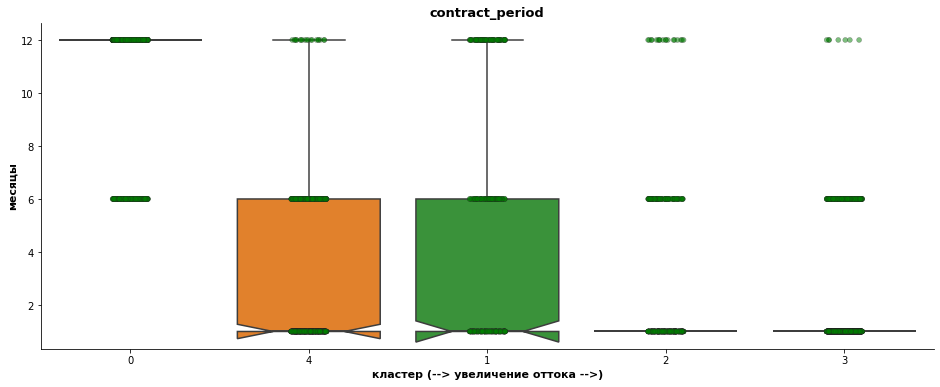

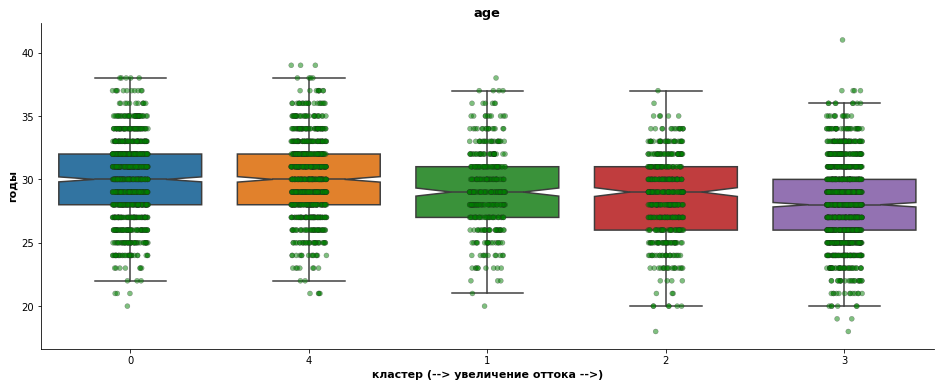

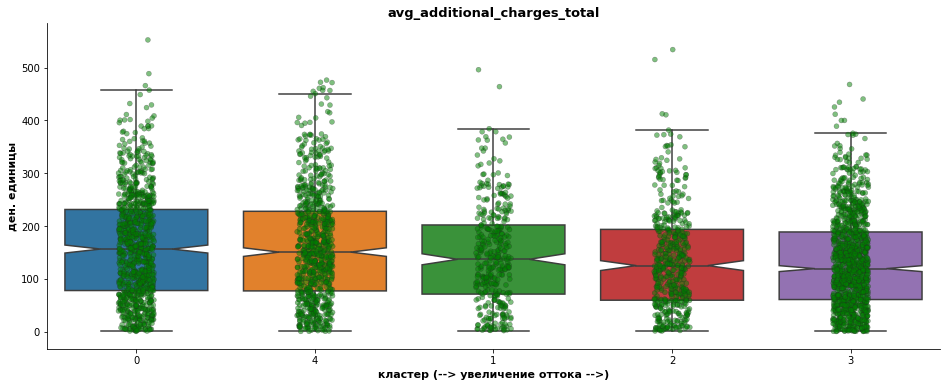

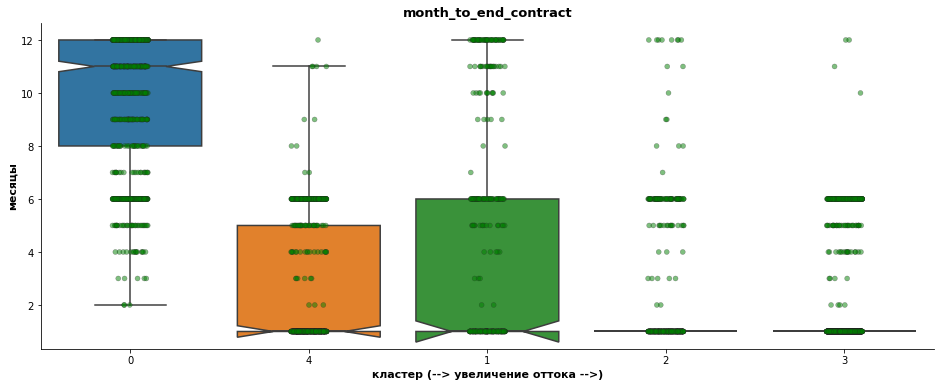

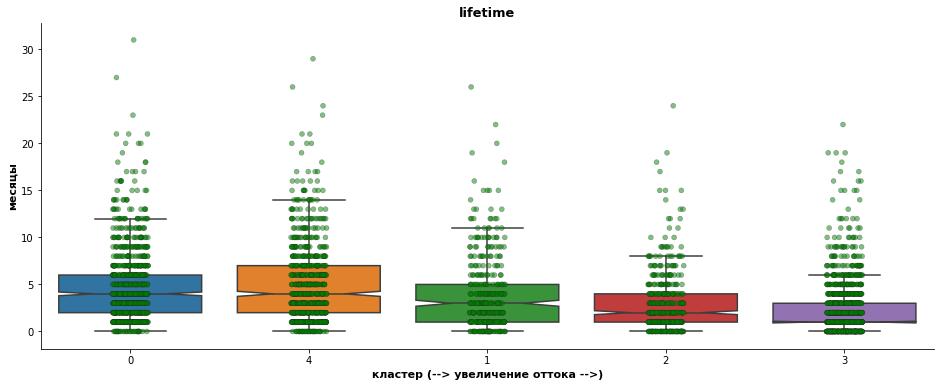

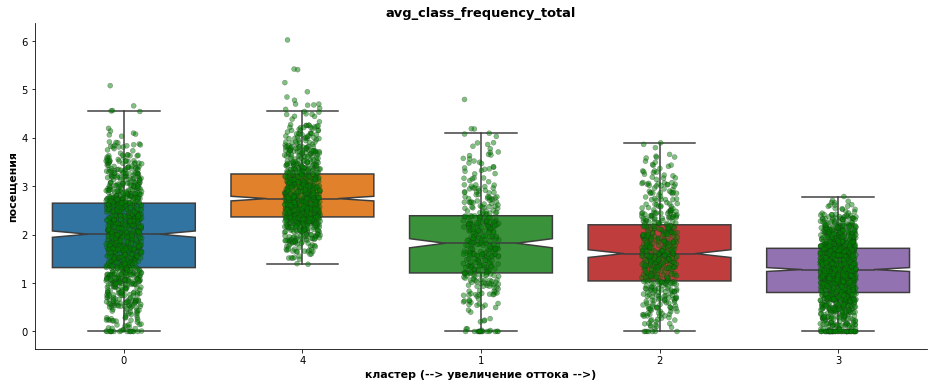

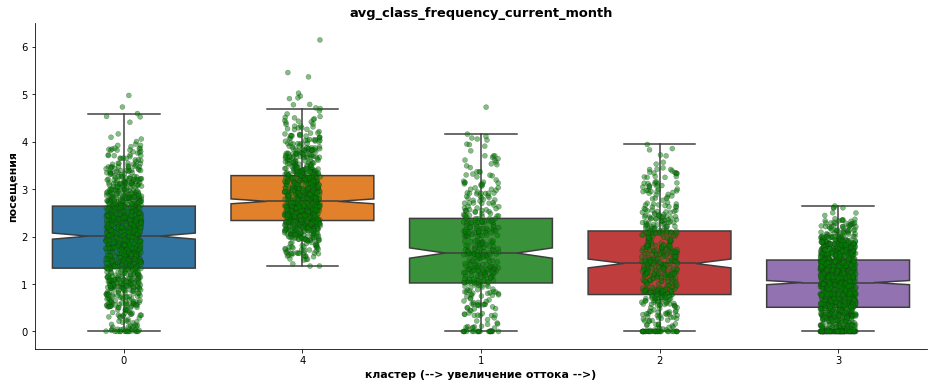

In [28]:
show_sign_distributions(figsize=(16, 6),
                        data=data,
                        group_sign='cluster',
                        xlabel='кластер (--> увеличение оттока -->)',
                        order=signsMeansByGroups.columns.to_list()
                        )


**Выводы**: 
После изучения диаграмм размаха, в добавок к выводам из таблицы со средними значениями, можно добавить, что зависимость оттока от возраста имеет не ярковыраженную, но четкую направленность. Чем старше клиенты, тем они лояльнее.

[К содержанию](#0.)
<a id='4.'></a>
#  4. Выводы и базовые рекомендации по работе с клиентами

**Общие выводы**:
 - В задаче по предсказанию оттока лучше справился алгоритм **Логистическая регрессия** с наиболее подходящей метрикой **Recall**, равной 0.846
 - Алгоритм кластеризации выделил два кластера с высокой долей оттока (около 50%): 2 и 3. Особенности клиентов в этих кластерах (по сравнению с более лояльными):
  - Меньше клиентов по партнерской программе
  - Меньше клиентов, которых привел друг
  - Меньше размер купленного абонемента
  - Меньше посещений групповых занятий
  - Немного меньше возраст
  - Меньше затрат на дополнительные услуги
  - Меньше прошло времени с первого визита
  - Меньше частота посещений
  
  
**Рекомендации**:
 - Удерживать клиента, пока он не состарится :). В этом случае достигается кумулятивный эффект :)
 - Анкетировать клиентов о месте работы и, например, при многочисленных совпадениях - предлагать этим работодателям партнерские программы.
 - Мотивировать клиентов приглашать своих друзей с помощью различных бонусов: доп. услуги, групповые занятия, увеличение размера абонемента.
 - Скидки на групповые занятия для новых(например, менее 6 месяцев) клиентов
 - Рекламировать доп.услуги и дарить купоны со скидками на них новым клиентам